In [45]:
### loading code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

df = pd.read_csv("risk_factors_cervical_cancer.csv")
print(df)

     Age Number of sexual partners First sexual intercourse  \
0     18                       4.0                     15.0   
1     15                       1.0                     14.0   
2     34                       1.0                        ?   
3     52                       5.0                     16.0   
4     46                       3.0                     21.0   
..   ...                       ...                      ...   
853   34                       3.0                     18.0   
854   32                       2.0                     19.0   
855   25                       2.0                     17.0   
856   33                       2.0                     24.0   
857   29                       2.0                     20.0   

    Num of pregnancies Smokes Smokes (years) Smokes (packs/year)  \
0                  1.0    0.0            0.0                 0.0   
1                  1.0    0.0            0.0                 0.0   
2                  1.0    0.0          

In [46]:
#replace '?' with NaN and convert to numeric
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric, errors="coerce")
df.info()
print("\n")
missingRatio = df.isna().mean().sort_values(ascending=False)
print(missingRatio)

#drop columns with too many missing values
df = df.drop(columns=["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

In [47]:
#binary columns imputation
binaryCols = [c for c in df.columns if df[c].dropna().isin([0,1]).all()]
binaryImputer = SimpleImputer(strategy="most_frequent")
df[binaryCols] = binaryImputer.fit_transform(df[binaryCols])

#continuous columns imputation
continuousCols = list(set(df.columns) - set(binaryCols))
numericalImputer = SimpleImputer(strategy="median")
df[continuousCols] = numericalImputer.fit_transform(df[continuousCols])


In [48]:
# Target vs features
y = df["Biopsy"]
X = df.drop("Biopsy", axis=1)

print("Target class distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


Target class distribution:
Biopsy
0.0    803
1.0     55
Name: count, dtype: int64
Biopsy
0.0    0.935897
1.0    0.064103
Name: proportion, dtype: float64


In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced")
}

for name, m in models.items():
    m.fit(X_train_scaled, y_train)
    y_pred = m.predict(X_test_scaled)
    y_prob = m.predict_proba(X_test_scaled)[:, 1]
    print("\n-----------------")
    print(name)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))


-----------------
LogReg
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       201
         1.0       0.55      0.79      0.65        14

    accuracy                           0.94       215
   macro avg       0.77      0.87      0.81       215
weighted avg       0.96      0.94      0.95       215

ROC AUC: 0.9214641080312722

-----------------
RandomForest
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       201
         1.0       0.67      0.43      0.52        14

    accuracy                           0.95       215
   macro avg       0.81      0.71      0.75       215
weighted avg       0.94      0.95      0.94       215

ROC AUC: 0.9699715707178393

-----------------
SVM
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       201
         1.0       0.60      0.64      0.62        14

    accuracy                           0.95  

In [51]:
# Random Forest feature importance
rf = models["RandomForest"]
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)
print("\nTop 10 important features:")
print(feat_imp.head(10))


Top 10 important features:
Schiller                           0.376777
Hinselmann                         0.122203
First sexual intercourse           0.069505
Age                                0.061935
Hormonal Contraceptives (years)    0.053218
Citology                           0.052112
Number of sexual partners          0.042813
Num of pregnancies                 0.042664
Dx                                 0.028231
Dx:CIN                             0.022777
dtype: float64


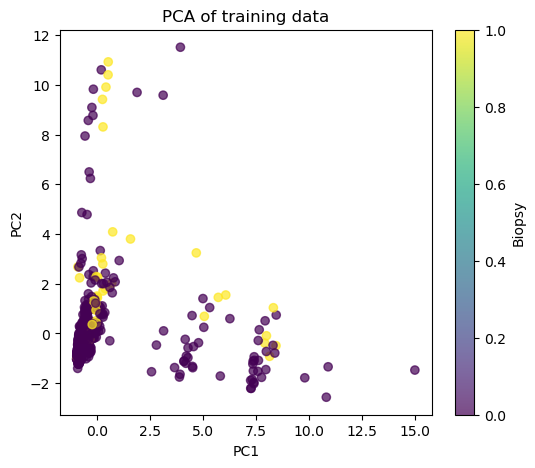

Explained variance: [0.16586279 0.10621059]


In [52]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of training data")
plt.colorbar(label="Biopsy")
plt.show()

print("Explained variance:", pca.explained_variance_ratio_)

C:\Users\edwar\miniconda3\envs\bima\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


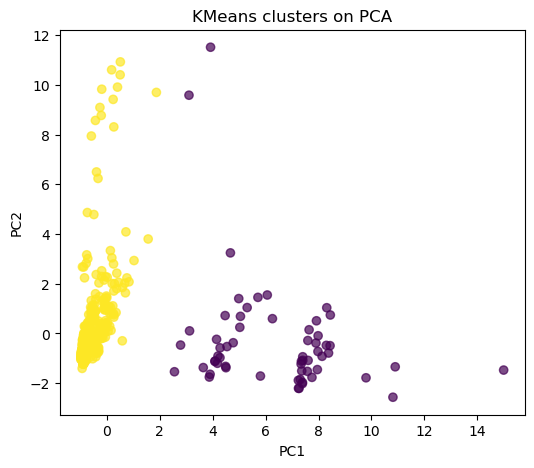

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=clusters, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans clusters on PCA")
plt.show()

In [54]:
corrs = df.corr()["Biopsy"].sort_values()
print("\nCorrelations with Biopsy:")
print(corrs)


Correlations with Biopsy:
STDs:syphilis                        -0.038311
Hormonal Contraceptives              -0.018015
STDs:vaginal condylomatosis          -0.017911
STDs:HPV                             -0.012650
STDs:pelvic inflammatory disease     -0.008940
STDs:Hepatitis B                     -0.008940
STDs:molluscum contagiosum           -0.008940
Number of sexual partners            -0.000408
First sexual intercourse              0.007259
Smokes (packs/year)                   0.024487
Smokes                                0.028724
IUD (years)                           0.038176
Num of pregnancies                    0.040215
Age                                   0.055956
IUD                                   0.059231
Smokes (years)                        0.061204
STDs:condylomatosis                   0.090164
STDs:vulvo-perineal condylomatosis    0.092548
Hormonal Contraceptives (years)       0.094164
STDs: Number of diagnosis             0.097449
STDs (number)                    

In [55]:
lr_pca = LogisticRegression(class_weight="balanced")
lr_pca.fit(X_train_pca, y_train)
y_prob_pca = lr_pca.predict_proba(X_test_pca)[:,1]
print("\nLogReg on PCA features ROC AUC:", roc_auc_score(y_test, y_prob_pca))


LogReg on PCA features ROC AUC: 0.8756218905472637


In [56]:
test_feats = ["Hinselmann", "Schiller", "Citology"]
X_testonly = df[test_feats]

Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_testonly, y, test_size=0.25, stratify=y, random_state=42
)

Xt_train_scaled = scaler.fit_transform(Xt_train)
Xt_test_scaled = scaler.transform(Xt_test)

lr_tests = LogisticRegression(class_weight="balanced")
lr_tests.fit(Xt_train_scaled, yt_train)
yt_prob = lr_tests.predict_proba(Xt_test_scaled)[:,1]

print("\nLogReg with only screening tests ROC AUC:", roc_auc_score(yt_test, yt_prob))


LogReg with only screening tests ROC AUC: 0.9426083866382373


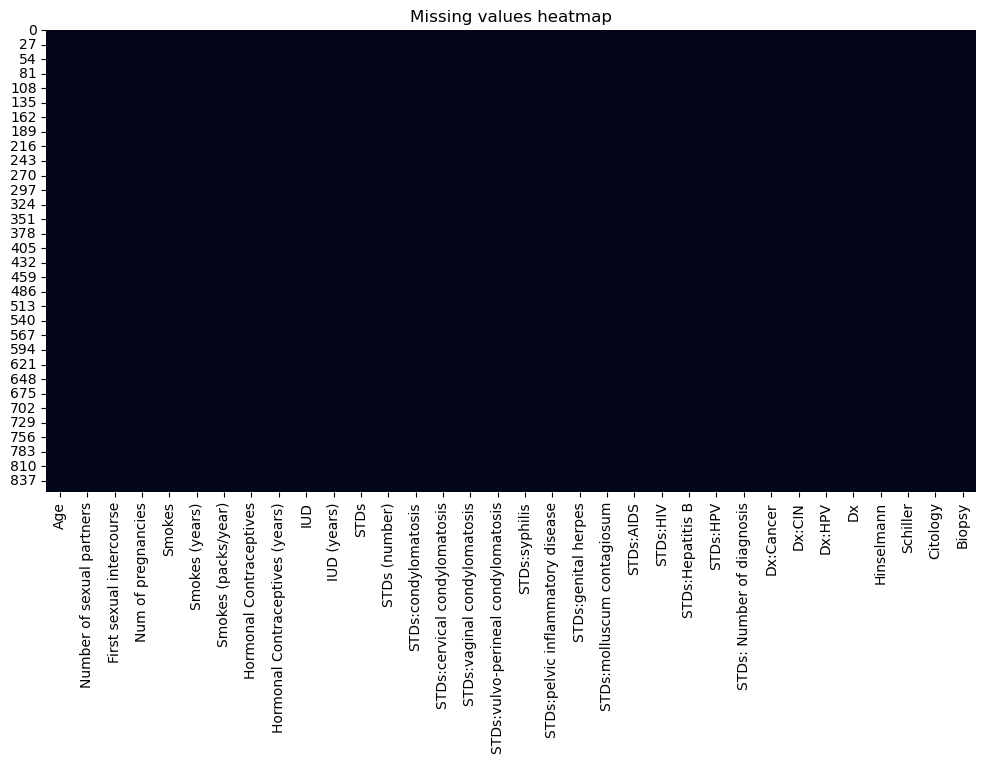

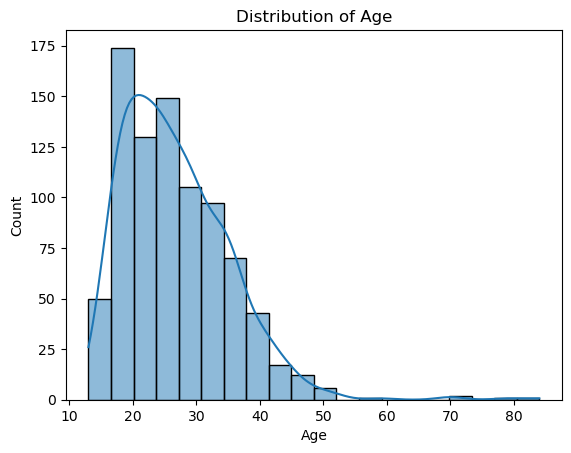

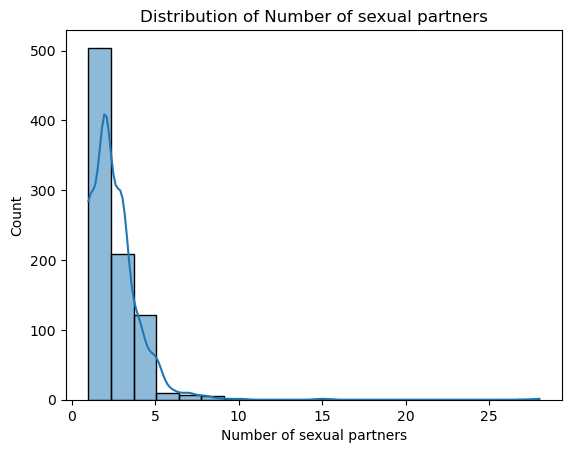

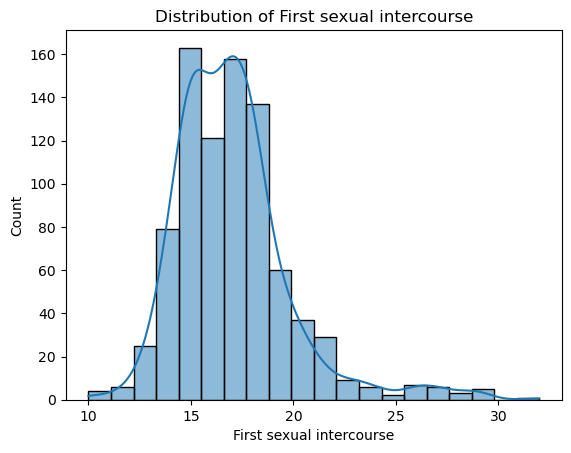

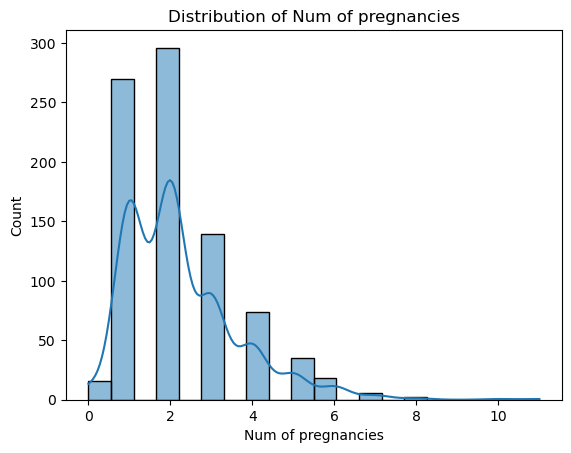

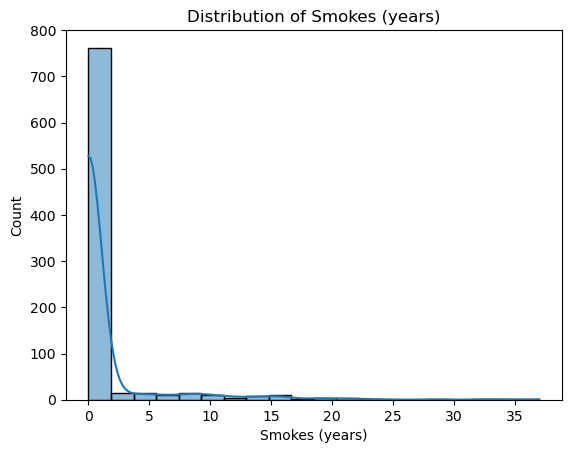

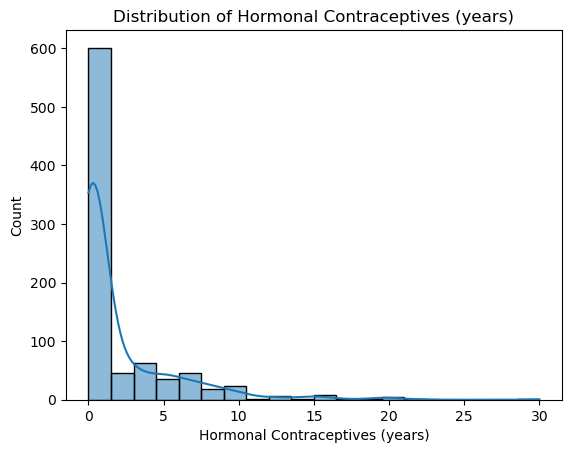

In [57]:
# Missing values heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing values heatmap")
plt.show()

# Numeric distributions
num_feats = ["Age", "Number of sexual partners", "First sexual intercourse",
             "Num of pregnancies", "Smokes (years)", "Hormonal Contraceptives (years)"]

for f in num_feats:
    plt.figure()
    sns.histplot(df[f], bins=20, kde=True)
    plt.title(f"Distribution of {f}")
    plt.show()

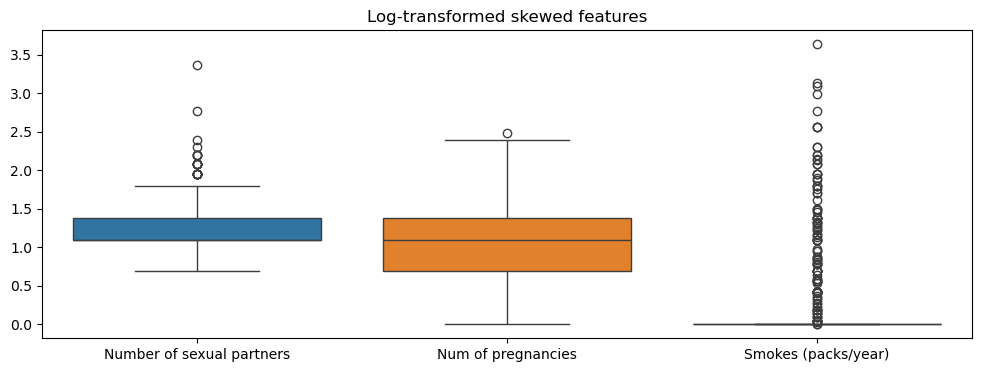

In [58]:
skewed = ["Number of sexual partners", "Num of pregnancies", "Smokes (packs/year)"]
df_log = df.copy()
for f in skewed:
    df_log[f] = np.log1p(df_log[f])

plt.figure(figsize=(12,4))
sns.boxplot(data=df_log[skewed])
plt.title("Log-transformed skewed features")
plt.show()

In [59]:
# MinMax scaling
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)
print("MinMax scaled sample features:")
print(X_train_mm[:5])

# KNN imputation
knn_imp = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imp.fit_transform(df), columns=df.columns)
print("\nMissing values after KNN imputation:")
print(df_knn.isna().sum())

MinMax scaled sample features:
[[0.33333333 0.03703704 0.77272727 0.2        0.         0.
  0.         1.         0.05       0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.34848485 0.         0.27272727 0.3        0.         0.
  0.         1.         0.55       0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.31818182 0.03703704 0.5        0.1        0.         0.
  0.         0.         0.         0.         0.         1.
  0.25       0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.33333333 0.         0.         0.         

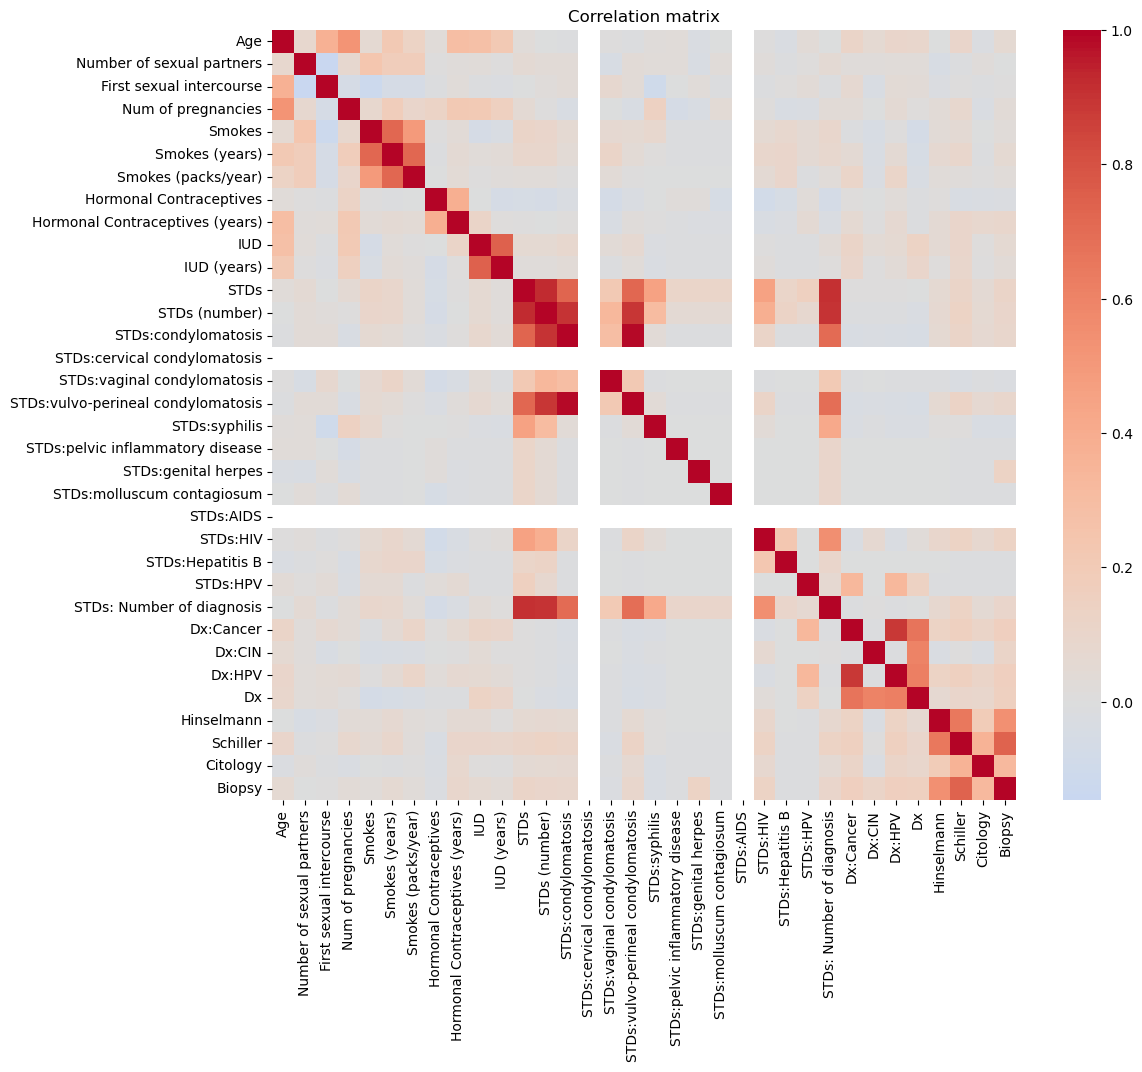

In [60]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()


In [61]:
gb = GradientBoostingClassifier(n_estimators=300, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
y_prob_gb = gb.predict_proba(X_test_scaled)[:,1]

print("\nGradient Boosting results")
print(classification_report(y_test, y_pred_gb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_gb))


Gradient Boosting results
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       201
         1.0       0.67      0.57      0.62        14

    accuracy                           0.95       215
   macro avg       0.82      0.78      0.80       215
weighted avg       0.95      0.95      0.95       215

ROC AUC: 0.9264392324093816


In [62]:
cv_scores = cross_val_score(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    X_train_scaled, y_train, cv=5, scoring="roc_auc"
)
print("\nLogReg 5-fold CV ROC AUC:", cv_scores)
print("Mean:", cv_scores.mean())



LogReg 5-fold CV ROC AUC: [0.9214876  0.95867769 0.96203704 0.95208333 0.94479167]
Mean: 0.9478154652586472


In [63]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE class distribution:")
print(pd.Series(y_train_sm).value_counts())

lr_sm = LogisticRegression(max_iter=1000)
lr_sm.fit(X_train_sm, y_train_sm)
y_pred_sm = lr_sm.predict(X_test_scaled)
y_prob_sm = lr_sm.predict_proba(X_test_scaled)[:,1]

print("\nLogReg with SMOTE")
print(classification_report(y_test, y_pred_sm))
print("ROC AUC:", roc_auc_score(y_test, y_prob_sm))



After SMOTE class distribution:
Biopsy
0.0    602
1.0    602
Name: count, dtype: int64

LogReg with SMOTE
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       201
         1.0       0.58      0.79      0.67        14

    accuracy                           0.95       215
   macro avg       0.78      0.87      0.82       215
weighted avg       0.96      0.95      0.95       215

ROC AUC: 0.8681592039800995


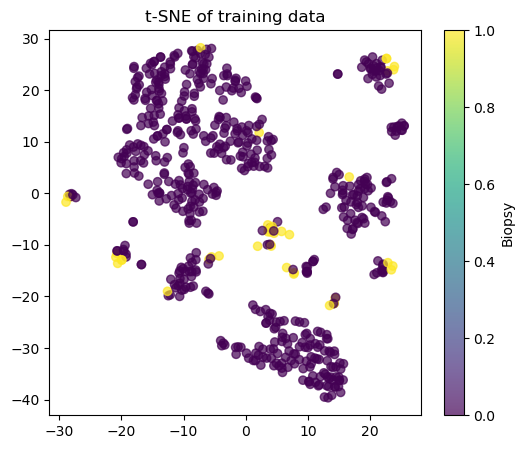

In [64]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=y_train, alpha=0.7)
plt.title("t-SNE of training data")
plt.colorbar(label="Biopsy")
plt.show()


In [65]:
sel = SelectKBest(score_func=f_classif, k=10)
X_top = sel.fit_transform(X_train_scaled, y_train)
top_feats = X_train.columns[sel.get_support()]
print("\nTop 10 features by ANOVA F-test:")
print(top_feats)

lr_fs = LogisticRegression(class_weight="balanced", max_iter=1000)
lr_fs.fit(X_train_scaled[:, sel.get_support()], y_train)
y_prob_fs = lr_fs.predict_proba(X_test_scaled[:, sel.get_support()])[:,1]
print("\nLogReg on top features ROC AUC:", roc_auc_score(y_test, y_prob_fs))



Top 10 features by ANOVA F-test:
Index(['STDs', 'STDs:HIV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN',
       'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology'],
      dtype='object')

LogReg on top features ROC AUC: 0.9118692253020613


C:\Users\edwar\miniconda3\envs\bima\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [14 19 20 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\edwar\miniconda3\envs\bima\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [66]:
# baseline
X_base = df.drop("Biopsy", axis=1)
y_base = df["Biopsy"]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.25, stratify=y_base, random_state=42
)
scaler = StandardScaler()
Xb_train = scaler.fit_transform(Xb_train)
Xb_test = scaler.transform(Xb_test)
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(Xb_train, yb_train)
yb_prob = lr.predict_proba(Xb_test)[:, 1]
roc_no_log = roc_auc_score(yb_test, yb_prob)

# log-transformed
X_log = df_log.drop("Biopsy", axis=1)
y_log = df_log["Biopsy"]
Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    X_log, y_log, test_size=0.25, stratify=y_log, random_state=42
)
Xl_train = scaler.fit_transform(Xl_train)
Xl_test = scaler.transform(Xl_test)
lr_log = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_log.fit(Xl_train, yl_train)
yl_prob = lr_log.predict_proba(Xl_test)[:, 1]
roc_log = roc_auc_score(yl_test, yl_prob)

print("\nExperiment 2 – Log transform comparison")
print("ROC AUC without log-transform:", roc_no_log)
print("ROC AUC with log-transform   :", roc_log)



Experiment 2 – Log transform comparison
ROC AUC without log-transform: 0.9214641080312722
ROC AUC with log-transform   : 0.9111584932480455
